In [465]:
from collections import Counter
import random
import numpy as np
import pandas as pd
from numpy import genfromtxt
from scipy import io
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
#from pydot import graph_from_dot_data
#import io

eps = 1e-5  # a small number




if __name__ == "__main__":
    data = io.loadmat('../hw5/datasets/spam_data/spam_data.mat')
    #print("\nloaded %s data!" % data)
    fields = "training_data", "test_data", "training_labels"
    for field in fields:
        print(field, data[field].shape)




training_data (5629, 32)
test_data (5400, 32)
training_labels (1, 5629)


In [466]:
X_test = data['test_data']

In [467]:
class Node():
    def __init__(self, idx=None, thresh=None, left=None, right=None, info_gain=None, value=None):
        ''' constructor ''' 
        
        # for decision nodeidx
        self.idx = idx
        self.thresh = thresh
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [468]:
class DecisionTree():
    def __init__(self, min_split=2, max_depth=2, feature_labels = None):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_split = min_split
        self.max_depth = max_depth
        self.pred = None
        self.features = feature_labels
        
    def build_tree(self, dataset, curr_depth=0, random_subspace=None):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if (num_samples >= self.min_split) and (curr_depth<=self.max_depth): 
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features, random_subspace)
            # check if information gain is positive
            if best_split and best_split.get("info_gain", 0) > 0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1, random_subspace)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1, random_subspace)
                # return decision node
                return Node(best_split["idx"], best_split["thresh"], 
                            left_subtree, right_subtree, best_split["info_gain"])                

        # compute leaf node
        leaf_value = self.leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features, random_subspace=None):
        ''' function to find the best split '''
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        if random_subspace and random_subspace <= num_features:
            feature_indices = random.sample(population=list(range(num_features)), k=random_subspace)
        else:
            feature_indices = list(range(num_features))


        # loop over all the features
        for idx in feature_indices:     
            feature_values = dataset[:, idx] 
            possible_thresholds = np.unique(feature_values)
        # loop over all the feature values present in the data
            for thresh in possible_thresholds:
            # get current split
                dataset_left, dataset_right = self.split(dataset, idx, thresh)
            # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "entropy")
                # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["idx"] = idx
                        best_split["thresh"] = thresh
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain  
                    

        # return best split
        return best_split
        
            
    
    def split(self, dataset, idx, thresh):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[idx]<=thresh])
        dataset_right = np.array([row for row in dataset if row[idx]>thresh])
        return dataset_left, dataset_right
    
    


    def information_gain(self, parent, left_child, right_child, mode="gini"):
        ''' function to compute information gain '''
        
        weight_left = len(left_child) / len(parent)
        weight_right = len(right_child) / len(parent)
        if mode=="gini":
            gain = self.gini(parent) - (weight_left*self.gini(left_child) + weight_right*self.gini(right_child))
        else:
            gain = self.entropy(parent) - (weight_left*self.entropy(left_child) + weight_right*self.entropy(right_child))
        return gain
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        labels = np.unique(y)
        entropy = 0
        for ls in labels:
            p_ls = len(y[y == ls]) / len(y)
            entropy += -p_ls * np.log2(p_ls)
        return entropy
    
    def gini(self, y):
        ''' function to compute gini index '''
        
        labels = np.unique(y)
        gini = 0
        for ls in labels:
            p_ls = len(y[y == ls]) / len(y)
            gini += p_ls**2
        return 1 - gini
        
    def leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
        

    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        preditions = [self.one_prediction(x, self.root) for x in X]
        return preditions
    
    def one_prediction(self, x, tree):
        
        if tree.value!=None: 
            return tree.value
        feature_val = x[tree.idx]
        if feature_val<=tree.thresh:
            return self.one_prediction(x, tree.left)
        else:
            return self.one_prediction(x, tree.right)

    def print_predict(self, x):
        ''' 
        Function to print the splits made by the decision tree for a given data point.
        '''
        # Ensure that the tree has been built
        if self.root is None:
            return
        
        # Get the prediction path for the given data point
        prediction_path = self.get_prediction_path(x, self.root, [])
        
        # Print the splits and the final prediction
        for idx, node in enumerate(prediction_path[:-1]):
            if node.left == prediction_path[idx+1]:
                direction = "<="
            else:
                direction = ">"
            print(f"({self.features[node.idx]} {direction} {node.thresh})")
        pred = ''
        if prediction_path[-1].value == 0:
            pred = 'ham email'
        else:
            pred = 'spam email'
        print("Therefore this email was", pred)
    
        
    
    def get_prediction_path(self, x, tree, path):
        '''
        Helper function to get the prediction path for a given data point.
        '''
        path.append(tree)
        if tree.value is not None:
            return path
        feature_val = x[tree.idx]
        if feature_val <= tree.thresh:
            return self.get_prediction_path(x, tree.left, path)
        else:
            return self.get_prediction_path(x, tree.right, path)


In [469]:
class RandomForest(DecisionTree):
    
    def __init__(self, n_trees, n_bootstrap, n_features, max_depth): #n_tree larger meaning better avoid overfitting
        self.rf_root = None
        self.n_trees = n_trees
        self.n_bootstrap = n_bootstrap
        self.n_features = n_features
        self.max_depth = max_depth
        #self.min_splits = min_splits
        #self.bags = [DecisionTree(self.max_depth, self.min_splits) for i in range(self.n_bootstrap)]
        super().__init__()#max_depth=max_depth)
    
    def bootstrap(self, dataset):
        np.random.seed(420)

        bootstrap_indices = np.random.randint(low=0, high=dataset.shape[0], size=self.n_bootstrap)
        dataset_bootstrapped = dataset[bootstrap_indices] #dataset being multidimensional array
    
        return dataset_bootstrapped
    
    

    def fit(self, X, Y):
        forest = []
        dataset = np.concatenate((X, Y), axis=1)
    
        for i in range(self.n_bootstrap):
            dataset_bootstrapped = self.bootstrap(dataset)
            tree = self.build_tree(dataset_bootstrapped, curr_depth=0, random_subspace=self.n_features)
            forest.append(tree)
        self.rf_root = forest
        

    def predict(self, X):
        rf_predictions = {}
        for i in range(len(self.rf_root)):
            column_name = "tree()".format(i)
            predictions = [DecisionTree().one_prediction(x, self.rf_root[i]) for x in X]
            rf_predictions[column_name] = predictions

        rf_predictions = pd.DataFrame(rf_predictions)
        random_forest_predictions = rf_predictions.mode(axis=1)[0]

        return random_forest_predictions
    
    
    


In [470]:
#spam/ham

In [471]:


X = data['training_data']
Y = data['training_labels'].reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.2, random_state=7)


In [472]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

features = np.array([
"pain", "private", "bank", "money", "drug", "spam", "prescription", "creative", "height", "featured", "differ", "width", "other", "energy", "business", "message", "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out", "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket", "ampersand"
])
assert len(features) == 32

class_label = ['ham','spam']    

classifier = DecisionTree(min_split=2, max_depth=10, feature_labels = features)
classifier.fit(X_train, Y_train)
Y_pred_train = classifier.predict(X_train)
Y_pred_val = classifier.predict(X_val)

#4.4 decision tree, spam/ham
spam_val_accuracy = accuracy_score(Y_val, Y_pred_val)
spam_train_accuracy = accuracy_score(Y_train, Y_pred_train)
print('DecisionTree training accuracy of spam data is:', spam_train_accuracy)
print('DecisionTree validation accuracy of spam data is:', spam_val_accuracy)

#4.5.2 tree split for one single data
classifier.print_predict(X_train[10])#, class_label)
classifier.print_predict(X_train[0])

DecisionTree training accuracy of spam data is: 0.8525427492782589
DecisionTree validation accuracy of spam data is: 0.8339253996447602
(exclamation <= 0.0)
(parenthesis > 0.0)
(money <= 0.0)
(dollar <= 1.0)
(energy <= 0.0)
(meter <= 0.0)
(pain <= 0.0)
(featured <= 0.0)
(message <= 0.0)
(bank <= 0.0)
(spam <= 0.0)
Therefore this email was ham email
(exclamation > 0.0)
(parenthesis > 0.0)
(dollar > 1.0)
(exclamation <= 3.0)
(ampersand <= 0.0)
(parenthesis <= 16.0)
(energy <= 0.0)
(semicolon <= 0.0)
(other <= 0.0)
(volumes <= 0.0)
(record <= 1.0)
Therefore this email was spam email


Text(0, 0.5, 'validation_accuracy')

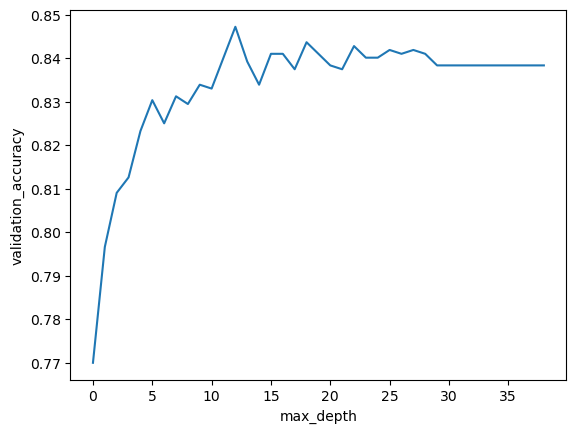

In [473]:
#4.5.3 visualization of spam data
plot_y = []
for i in range(1, 40):
    one_clf = DecisionTree(min_split=1, max_depth=i)
    one_clf.fit(X_train, Y_train)
    one_pred = one_clf.predict(X_val)
    one_val_acc = accuracy_score(Y_val, one_pred)
    plot_y.append(one_val_acc)
    
plt.plot(plot_y)
plt.xlabel('max_depth')
plt.ylabel('validation_accuracy')
#4.5.3 From the plot, it seems that the validation accuracy stays stable after about 10 for max_depth with an accuracy of between 0.84.

In [474]:
#4.4 randomforest spam train/val data

rf_spam_class = RandomForest(n_trees = 10, n_bootstrap = 50, n_features = 20, max_depth = 10)
rf_spam_class.fit(X_train, Y_train)
rf_spam_Y_pred_val = rf_spam_class.predict(X_val)
rf_spam_Y_pred_train = rf_spam_class.predict(X_train)
val_accuracy_rf = accuracy_score(Y_val, rf_spam_Y_pred_val)
train_accuracy_rf = accuracy_score(Y_train, rf_spam_Y_pred_train)

print('RainForest training accuracy of spam data is:', train_accuracy_rf)
print('RainForest validation accuracy of spam data is:', val_accuracy_rf)

RainForest training accuracy of spam data is: 0.7181878747501665
RainForest validation accuracy of spam data is: 0.7255772646536413


In [475]:
titanic_whole_data = pd.read_csv("../hw5/datasets/titanic/titanic_training.csv")#, skiprows=1, header=None, names=col_names)
titanic_test = pd.read_csv("../hw5/datasets/titanic/titanic_testing_data.csv")
titanic_data = titanic_whole_data.drop(columns = ['survived'])
titanic_label = titanic_whole_data['survived']

# replace NAN to mode via pandas trick 
#use one_hot_encode pclass to first,second,third, sex to male 0, female 1, 
#for missing value in sex, use mode of sex; for age missing value, use mode of age in (pclass, sex); for cabin, mode of cabin in pclass

In [477]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def impute_encode(data):
    
    categorical_cols = [col for col in data.columns if col in ['sex','embarked', 'pclass']]
    numerical_cols = [col for col in data.columns if col in ['age','sibsp','parch','fare']]

    # Step 2: Impute missing values in numerical columns using KNN
    imputer = KNNImputer(n_neighbors=2)
    titanic_data_num = imputer.fit_transform(data[numerical_cols])
    titanic_data_num = pd.DataFrame(data = titanic_data_num, columns= ['age','sibsp','parch','fare'])
    #experiment_titanic = pd.concat([titanic_data[categorical_cols], titanic_data_num],axis=0)
    #experiment_titanic
    titanic_data_num

    #step 3: impute missing value of categorical column
    intermediate = pd.concat([titanic_data_num, data[['sex','embarked']]], axis = 1)
    intermediate
    
    intermediate.sex = intermediate.sex.map({'male':0, 'female':1})
    intermediate.embarked = intermediate.embarked.map({'S':0, 'C':1, 'Q':2})

    new_intermediate = imputer.fit_transform(intermediate)
    new_intermediate = pd.DataFrame(data = new_intermediate, columns= ['age','sibsp','parch','fare','sex','embarked'])
    new_intermediate['pclass'] = data['pclass']
    new_intermediate
    new_intermediate.sex = new_intermediate.sex.replace({1:10})
    new_intermediate.pclass = new_intermediate.pclass.replace({1: 10, 3: 0})


    #step 4 one hot encode
    ohe = OneHotEncoder()
    one_hot_encoded = ohe.fit_transform(new_intermediate[['sex','embarked','pclass']]).toarray()
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=ohe.get_feature_names_out())
    revised_titanic = pd.concat([new_intermediate, one_hot_encoded_df], axis=1)
    revised_titanic.drop(columns=['sex','embarked','pclass'], inplace=True)
    return new_intermediate
    

In [478]:
new_intermediate.sex = new_intermediate.sex.replace(1,6)
new_intermediate.pclass = new_intermediate.pclass.replace({1: 6, 3: 1})


In [479]:
#4.4 decision tree titanic data

X_titanic = impute_encode(titanic_data).values
Y_titanic = titanic_label.values.reshape(-1,1)

X_train_titanic, X_val_titanic, Y_train_titanic, Y_val_titanic = train_test_split(X_titanic, Y_titanic, test_size=.2, random_state=420)

classifier_titanic = DecisionTree(min_split=2, max_depth=4, feature_labels = impute_encode(titanic_data).columns.values)
classifier_titanic.fit(X_train_titanic, Y_train_titanic)
Y_pred_train_titanic = classifier_titanic.predict(X_train_titanic)
Y_pred_val_titanic = classifier_titanic.predict(X_val_titanic)

dt_train_acc_titanic = accuracy_score(Y_pred_train_titanic, Y_train_titanic)
dt_val_acc_titanic = accuracy_score(Y_pred_val_titanic, Y_val_titanic)

print('DecisionTree titanic data training accuracy is:', dt_train_acc_titanic)
print('DecisionTree titanic data validation accuracy is:', dt_val_acc_titanic)

DecisionTree titanic data training accuracy is: 0.838909541511772
DecisionTree titanic data validation accuracy is: 0.7920792079207921


In [480]:
#4.4 randomforest titanic train/val data

rf_titanic_class = RandomForest(n_trees = 5, n_bootstrap = 50, n_features = 8, max_depth = 8)
rf_titanic_class.fit(X_train_titanic, Y_train_titanic)
rf_titanic_Y_pred_val = rf_titanic_class.predict(X_val_titanic)
rf_titanic_Y_pred_train = rf_titanic_class.predict(X_train_titanic)
val_accuracy_rf = accuracy_score(Y_val_titanic, rf_titanic_Y_pred_val)
train_accuracy_rf = accuracy_score(Y_train_titanic, rf_titanic_Y_pred_train)

print('RainForest training accuracy of spam data is:', train_accuracy_rf)
print('RainForest validation accuracy of spam data is:', val_accuracy_rf)


RainForest training accuracy of spam data is: 0.7608426270136307
RainForest validation accuracy of spam data is: 0.7475247524752475


In [481]:
import pandas as pd
def results_to_csv(y_test):
    #y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1 # Ensures that the index starts at 1
    if y_test == y_spam:
        df.to_csv('submission_spam.csv', index_label='Id')
    else:
        df.to_csv('submission_titanic.csv', index_label='Id')

In [482]:
y_spam = classifier.predict(X_test)
results_to_csv(y_spam)

In [483]:
y_titanic = classifier_titanic.predict(impute_encode(titanic_test).values)
results_to_csv(y_titanic)